# SVM Decision Boundary

###  <div align=center> Moon Il-chul(icmoon@kaist.ac.kr); Shin Dong-hyeok(tlsehdgur0@kaist.ac.kr); Kim Hye-mi(khm0308@kaist.ac.kr) </div>

본 코드는 Support Vector Machine을 이용하여 Decision Boundary를 찾아내는 구현 예시입니다.  
본 코드는 2차원 평면에 label되어있는 여러 데이터 중 몇 개의 점을 Support Vector로 활용하여 margin을 최대로하는 Decision Boundary를 찾습니다.  
본 코드를 통하여, 확률을 사용한 기존의 방법이 아닌 SVM을 통한 classification 과정을 익힐 수 있습니다.

### 배경이론 및 Margin

주어진 데이터를 linear Decision Boundary로 Classification할 때, 직관적으로 해당 Boundary와 가장 가까운 데이터의 거리가 가깝다면 error가 커질 수 있습니다. 따라서 여러 linear Decision Boundary 중에서 margin(Boundary와 가장 가까운 데이터와의 거리)이 최대가 되도록 하는 Boundary가 error를 줄여주는 좋은 Boundary라고 할 수 있습니다.

Linear Decision Boundary를 $f(x)=w \cdot x+b$라 하고 positive label을 갖는 점을 x라고 설정합니다. 이때, x는 positive label을 가지므로 Decision Boundary를 기준으로 양의 범위에 존재합니다.

$$f(x)=w \cdot x+b = a, a > 0$$

x에서 Decision Boundary로 내린 수선의 발을 $x_{p}$라 하면, x를 $x_{p}$에 관한 다음과 같은 식으로 나타낼 수 있습니다. ($r$: $x$와 $x_{p}$사이의 거리)

$$x = x_{p} + r\frac{w}{\rVert w \rVert}$$

또한 $x_{p}$는 Boundary위의 점이므로 $f(x_{p})=0$을 만족합니다. 


이를 이용하여 다음과 같은 유도과정을 통해 margin distance $r$을 얻을 수 있습니다.

$$f(x)=w \cdot x+b = w(x_{p} + r\frac{w}{\rVert w \rVert})+b 
= w \cdot x_{p}+b+r\frac{w \cdot w}{\rVert w \rVert}=r\rVert w \rVert$$
$$\therefore  r = \frac{f(x)}{\rVert w \rVert}$$

### Margin의 최대화
margin distrance 수식에서 $f(x)=a$로 바꾸어 $\frac{a}{\rVert w \rVert}$로 나타냅니다. 여기서 실제로 maximize할 거리는 Decision Boundary로 부터 Positive case 및 Negative case를 모두 고려한 값이므로 optimization을 하는 목적식과 제약식은 아래와 같습니다. 여기서 $y_j$는 $j$번째 점에 대한 값으로, 해당하는 점이 Positive인 경우에는 1, Negative인 경우에는 -1입니다.

$$\max_{w,b}(\frac{2a}{\rVert w \rVert})$$
$$s.t.\space(wx_{j}+b)y_{j} \ge 1, \forall j$$

우리는 a를 초기에 임의의 값으로 설정했으므로, a를 normalize한 후 목적식을 역수를 취하면 아래와 같은 quadratic optimization problem을 얻을 수 있습니다. 
$$\min_{w,b}(\rVert w \rVert)$$
$$s.t.\space(wx_{j}+b)y_{j} \ge 1, \forall j$$


In [1]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Shin Dong-hyeok: tlsehdgur0@kaist.ac.kr; Kim Hye-mi: khm0308@kaist.ac.kr
'''

import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Positive / Negative 데이터 생성
pos = np.array([[3, 7], [4, 6], [5, 6], [7, 7], [8, 5]])
neg = np.array([[4, 5], [5, 5], [6, 3], [7, 4], [9, 4]])

# X : 전체 데이터를 저장
X = np.ones((pos.shape[0]+neg.shape[0], 2))
X[0:pos.shape[0], :] = pos # 앞부분(0~4)은 positive 데이터를 저장
X[pos.shape[0]:pos.shape[0]+neg.shape[0], :] = neg # 뒷부분(5~9)은 negative 데이터를 저장

# Y : 전체 데이터에 대한 label을 저장
Y = np.ones(pos.shape[0] + neg.shape[0])
Y[0:pos.shape[0]] = 1 # 앞부분(0~4)은 positive 데이터에 대한 label로 +1을 저장
Y[pos.shape[0]:pos.shape[0]+neg.shape[0]] = -1 # 뒷부분(5~9)은 negative 데이터에 대한 label로 -1을 저장

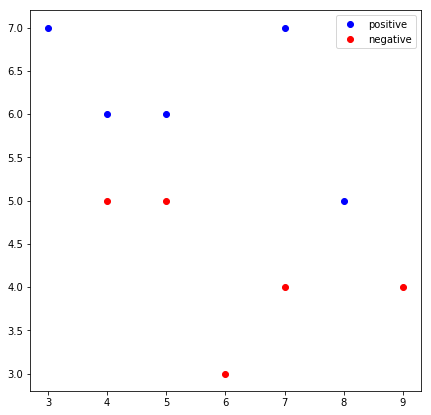

In [4]:
# 전체 데이터를 2차원 평면에 plot하는 과정
plt.figure(1, figsize = (7, 7))
plt.plot(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], 'bo', label = 'positive')
plt.plot(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 'ro', label = 'negative')
plt.legend()
plt.show()

In [5]:
# A: optimization problem에서 제약식 좌측항의 w의 계수(부등호 방향을 맞춰주기 위해 (-1)을 곱함)
A = np.zeros((X.shape[0], X.shape[1] + 1))
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        A[i, j] = X[i, j]*Y[i]*(-1)
    A[i, -1] = Y[i]*(-1)

# b: optimization problem에서 제약식 우측항의 값
b = np.ones(X.shape[0]) * (-1)

# H: w의 quadratic term의 계수
H = np.zeros((X.shape[1] + 1, X.shape[1] + 1))
for i in range(X.shape[1]): # 목적항에서 w1^2+w2^2의 계수
    H[i, i] = 1

# f: w의 일차항의 계수
f = np.zeros(X.shape[1]+1)

H = matrix(H)
f = matrix(f)
A = matrix(A)
b = matrix(b)

sol = solvers.qp(H, f, A, b) # min 1/2xTHx+fTx s.t. Ax =< b
w = sol['x'] # x의 해, w1, w2는 결정 경계선의 수선방향의 벡터, w3는 상수항

     pcost       dcost       gap    pres   dres
 0:  2.1959e-01  8.9396e+00  3e+01  2e+00  2e+01
 1:  3.4563e+00  1.5019e+00  6e+00  4e-01  3e+00
 2:  3.9159e+00  3.6051e+00  3e-01  1e-04  1e-03
 3:  3.7792e+00  3.7755e+00  4e-03  2e-06  1e-05
 4:  3.7778e+00  3.7778e+00  4e-05  2e-08  1e-07
 5:  3.7778e+00  3.7778e+00  4e-07  2e-10  1e-09
Optimal solution found.


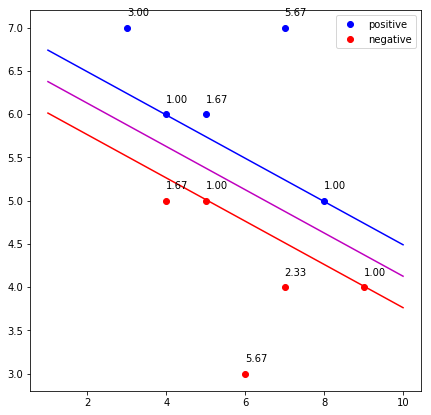

In [6]:
# Positive / Negative 데이터 plotting
plt.figure(1, figsize = (7, 7))
plt.plot(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], 'bo', label = 'positive')
plt.plot(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 'ro', label = 'negative')
plt.legend()

lineX = [1, 10]

# plotting decision-boundary
lineY0 = [(w[2] + w[0]*lineX[0])/-w[1], (w[2] + w[0]*lineX[1])/-w[1]]
plt.plot(lineX, lineY0, 'm-')

# margin distance 계산
margin = 1 / np.linalg.norm(w[0:2])

# Positive data 가운데 Negative data들과 가장 가까운 두개의 점을 지나는 직선
lineY1 = [(w[2] + w[0]*lineX[0])/-w[1] + margin, (w[2] + w[0]*lineX[1])/-w[1] + margin]
plt.plot(lineX, lineY1, 'b-')

# Negative data 가운데 Negative data들과 가장 가까운 점을 지나는 직선
lineY2 = [(w[2] + w[0]*lineX[0])/-w[1] - margin, (w[2] + w[0]*lineX[1])/-w[1] - margin]
plt.plot(lineX, lineY2, 'r-')

a = -1 * np.dot(A, w) # 각 점의 f(x)값

# 각 점에 f(x)=wx+b값을 나타냄
for i in range(X.shape[0]):
    plt.text(X[i, 0], X[i, 1], '%.2f\n'%a[i][0])

### 결과해석부
* 파랑색 점들은 Positive data set, 빨강색 점들은 Negative data set입니다.  
* 자주색 선은 SVM을 활용하여 구한 Decision Boundary입니다.  
* 각 점에 나타난 숫자는, Decision Boundary에서 해당 점까지의 거리에 비례하는 값인 $f(x)$을 나타냅니다.